In [2]:
import fermat as F
import numpy as np
import scipy.sparse as sp
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## 'data' is always given as np matrix where each row is a point in R**(#columns)

### fermat distance between two points (x,y) outside the manifold: choose the closest neighbour x' of the starting point  x and cost will be cost(x',y)+euclid_dist(x,x')**alpha
# OJO QUE EUCLID_DIST(X,X')  PORQUE EL MISMO PUNTO TIENE DISTANCIA POSITIVA CON SI MISMO!!

### gradient on y of fermat_dist(x,y) with x,y outside the manifold:  the k-nn of y with smallest fermat_cost(x',y)

In [3]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient


#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    assert(len(initialData.flatten())==len(x))
    dimension=initialData.shape[1]
    real_x=x.reshape(-1,dimension)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dimension*i:(i+1)*dimension]=local_gradient
    return res,gradient


A small example using these costs

In [4]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(6.688218234000335, array([1.61702278, 1.37730509, 1.96652496, 1.76456321, 1.27165148,
       1.36180989, 1.1185228 , 0.30285458, 0.42953411, 0.30185758,
       1.66140505, 0.64865926, 0.99633987, 1.09898986, 0.32054085,
       1.76741846]))


(2.462276531403042,
 array([1.1185228 , 0.30285458, 1.1185228 , 0.30285458, 1.1185228 ,
        0.30285458, 1.1185228 , 0.30285458, 0.42953411, 0.30185758,
        1.1185228 , 0.30285458, 1.1185228 , 0.30285458, 1.1185228 ,
        0.30285458]))

# To do: add kernels

In [5]:
##Minimize the transported of initialData (indexes of points from data) given the fermat_distances
#it recieves other parameters explained before as well as constraints, xinit and maxiter and method
#for the constrained-minimization
def fermat_opt_transport(initialData,dimension,fermat_distances,tree,data,k,alpha,cons,xinit,maxiter=100,method='trust-constr',callback=True):
    
    opt={"disp": False, "maxiter":maxiter}
    
    f= lambda x: fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha)
    
    global Nfeval
    Nfeval=1
    if callback:
        def callbackF(Xi,status):
            global Nfeval
            print ('Iter:'+ str(Nfeval)+', cost: '+str(f(Xi)[0])+',  max constr-viol:'+ str(np.max([abs(con['fun'](Xi)) for con in cons])))
            Nfeval += 1
    else:
        callbackF=None
    
    res = minimize(f, x0=xinit.flatten(), jac=True,constraints=cons,options=opt, method=method,callback=callbackF)
    return res

    
def constraints(initialPoints,finalData,first_moment=True, second_moment=True, kernel_centers=None, kernel_h=None):
    dimension=finalData.shape[1]
    finalPoints=finalData.shape[0]
    Y=finalData.flatten()
    cons=[]
    
    
    if first_moment:
        global aux
        aux=[]
        global b
        b=np.mean(finalData,axis=0)
        for i in range(dimension):
            to_repeat=np.array([1 if j==i else 0 for j in range(dimension)])
            aux.append(np.tile(to_repeat,initialPoints)/initialPoints)
            cons.append({'type': 'eq', 'fun': lambda x,i=i: aux[i]@x.T - b[i] ,'jac': lambda x,i=i: aux[i]})
            #HAY QUE PONER LAMBDA CON DOS PARAMETROS PARA QUE FIJE EL i Y NO LO CAMBIE
    
    select_restrictions=np.zeros((dimension,dimension))
    id_initialPoints=sp.eye(initialPoints)
    id_finalPoints=sp.eye(finalPoints)
    if second_moment:
        global A,B
        A=[]
        B=[]
        ij=0
        for i in range(dimension):
            for j in range(i,dimension):
                select_restrictions[j,i]=1
                A.append(sp.kron(id_initialPoints,select_restrictions)/initialPoints)               
                B.append(sp.kron(id_finalPoints,select_restrictions)/finalPoints)
                cons.append({'type': 'eq', 'fun': lambda x,ij=ij: (x@A[ij]@x.T)-(Y@B[ij]@Y.T),'jac': lambda x,ij=ij: 2*A[ij]@x.T})
                #HAY QUE PONER LAMBDA CON DOS PARAMETROS PARA QUE FIJE EL i Y NO LO CAMBIE
                select_restrictions[j,i]=0
                ij+=1
                
    ##TODO: IMPLEMENTAR LOS KERNEL
    
    return cons


A small example using fermat_opt_transport

In [6]:
data=np.random.random((10,2))

alpha=2
finalData=np.random.random((3,2))+4
initialData=data[0:8,:]
initialPoints=initialData.shape[0]
dimension=2
f_dist,tree=fermat_graph(data,alpha=alpha)
k=10

cons=constraints(initialPoints,finalData)



xinit=data[0:8,:]
maxiter=100


res=fermat_opt_transport(initialData,dimension,f_dist,tree,data,k,alpha,cons,xinit,maxiter)

Iter:1, cost: 0.0,  max constr-viol:22.021236710284864


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:2, cost: 0.6035978871037468,  max constr-viol:21.65272032572597


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:3, cost: 23.031825976687106,  max constr-viol:18.84057275115401
Iter:4, cost: 23.031825976687106,  max constr-viol:18.84057275115401


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:5, cost: 55.77343147067962,  max constr-viol:17.60988241026158
Iter:6, cost: 55.77343147067962,  max constr-viol:17.60988241026158


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:7, cost: 164.13776948141484,  max constr-viol:13.906468134990018
Iter:8, cost: 164.13776948141484,  max constr-viol:13.906468134990018


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:9, cost: 231.45604466071558,  max constr-viol:7.788426771120944
Iter:10, cost: 231.45604466071558,  max constr-viol:7.788426771120944


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:11, cost: 242.01988354122474,  max constr-viol:1.9243911222261758
Iter:12, cost: 242.01988354122474,  max constr-viol:1.9243911222261758


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'appro

Iter:13, cost: 250.7176472638,  max constr-viol:0.6515784692064095
Iter:14, cost: 250.7176472638,  max constr-viol:0.6515784692064095


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:15, cost: 248.69023619781433,  max constr-viol:0.26841081861101657


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:16, cost: 248.69023619781433,  max constr-viol:0.26841081861101657
Iter:17, cost: 247.14243523738978,  max constr-viol:0.14669479224652981


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:18, cost: 247.14243523738978,  max constr-viol:0.14669479224652981


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:19, cost: 246.34646619872672,  max constr-viol:0.13245849137460564


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:20, cost: 246.34646619872672,  max constr-viol:0.13245849137460564


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:21, cost: 246.00054002319942,  max constr-viol:0.1276235987376193
Iter:22, cost: 245.83560648178099,  max constr-viol:0.1274614324318879


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:23, cost: 245.7871040520651,  max constr-viol:0.10841599942871216
Iter:24, cost: 245.7871040520651,  max constr-viol:0.10841599942871216


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'appro

Iter:25, cost: 245.49790334293246,  max constr-viol:0.10571008983222008
Iter:26, cost: 245.46805445594822,  max constr-viol:0.0913073705184555


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:27, cost: 245.46805445594822,  max constr-viol:0.0913073705184555
Iter:28, cost: 245.16892897211704,  max constr-viol:0.08554801761119535


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:29, cost: 245.2523179746782,  max constr-viol:0.0779752148195092


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:30, cost: 245.2523179746782,  max constr-viol:0.0779752148195092
Iter:31, cost: 244.98993767080174,  max constr-viol:0.06999671434525556


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:32, cost: 244.70068349442246,  max constr-viol:0.05906776934672031
Iter:33, cost: 244.7915345963277,  max constr-viol:0.04533410075446298


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:34, cost: 244.7915345963277,  max constr-viol:0.04533410075446298
Iter:35, cost: 244.42756028794264,  max constr-viol:0.03586473159145953


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:36, cost: 244.42756028794264,  max constr-viol:0.03586473159145953
Iter:37, cost: 244.09810573784313,  max constr-viol:0.0304082246398778


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:38, cost: 244.09810573784313,  max constr-viol:0.0304082246398778
Iter:39, cost: 243.82325763452405,  max constr-viol:0.025292917918942948
Iter:40, cost: 243.82325763452405,  max constr-viol:0.025292917918942948


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:41, cost: 243.5867793170144,  max constr-viol:0.022087366865786606
Iter:42, cost: 243.5867793170144,  max constr-viol:0.022087366865786606


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:43, cost: 243.39448718962714,  max constr-viol:0.019273495623437498
Iter:44, cost: 243.39448718962714,  max constr-viol:0.019273495623437498


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:45, cost: 243.2511943936736,  max constr-viol:0.016097009397125106


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:46, cost: 243.13140291559358,  max constr-viol:0.013128382620116952
Iter:47, cost: 243.0311904350986,  max constr-viol:0.006359308751765269


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:48, cost: 242.98324573163902,  max constr-viol:0.0031757443471498448


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:49, cost: 242.961555432134,  max constr-viol:0.0015878715380814867
Iter:50, cost: 242.95092516638238,  max constr-viol:0.0007939357690425197


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:51, cost: 242.94583434952136,  max constr-viol:0.0003969678845194835
Iter:52, cost: 242.94329804025284,  max constr-viol:0.00019848394225974175


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'appro

Iter:53, cost: 242.94204607910632,  max constr-viol:9.924197112809452e-05
Iter:54, cost: 242.94142074619947,  max constr-viol:4.962098556404726e-05


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:55, cost: 242.9411095409298,  max constr-viol:2.4810492785576344e-05
Iter:56, cost: 242.9409541310988,  max constr-viol:1.2405246391011815e-05
Iter:57, cost: 242.94087661852404,  max constr-viol:6.202623197282264e-06
Iter:58, cost: 242.94083792844373,  max constr-viol:3.1013115950884185e-06


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:59, cost: 242.9408186245835,  max constr-viol:1.550655799320566e-06


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:60, cost: 242.94080899353054,  max constr-viol:7.753278978839262e-07
Iter:61, cost: 242.94080418977714,  max constr-viol:3.876639489419631e-07


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:62, cost: 242.94080179441679,  max constr-viol:1.938319762473384e-07
Iter:63, cost: 242.9408006003934,  max constr-viol:9.691598634731236e-08


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:64, cost: 242.94080000543585,  max constr-viol:4.845799139729934e-08
Iter:65, cost: 242.94079970911343,  max constr-viol:2.4228999251363348e-08


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:66, cost: 242.94079956160374,  max constr-viol:1.2114497849324835e-08
Iter:67, cost: 242.94079948821604,  max constr-viol:6.057248924662417e-09


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:68, cost: 242.94079945172913,  max constr-viol:3.0286244623312086e-09
Iter:69, cost: 242.9407994336024,  max constr-viol:1.5143122311656043e-09


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:70, cost: 242.94079942460473,  max constr-viol:7.571543392259628e-10
Iter:71, cost: 242.94079942014298,  max constr-viol:3.785771696129814e-10


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Iter:72, cost: 242.94079941793296,  max constr-viol:1.892885848064907e-10
Iter:73, cost: 242.94079941683975,  max constr-viol:9.464429240324534e-11
Iter:74, cost: 242.94079941629965,  max constr-viol:4.732214620162267e-11


/home/peron/.local/lib/python3.5/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


# Making easier to call it: fermat_ot wraps all the definitions, requiring only the problem of optimal transport input

### data: points defining fermat_graph
### initialData: [start,end), the points that will be transported are data[start:end,:]
### finalData: destination points (distribution)
### alpha: parameter used defining fermat_graph
### k: number of neighbours used to calculate gradient and fermat distance of points outside data
### xinit: initial value of the transported points


In [7]:
def fermat_ot(data,initialData,finalData,alpha,k,xinit,maxiter=100,first_moment=True,second_moment=True):
    initialPoints=initialData.shape[0]
    dimension=data.shape[1]
    f_dist,tree=fermat_graph(data,alpha)
    cons=constraints(initialPoints,finalData,first_moment,second_moment)
    res=fermat_opt_transport(initialData,dimension,f_dist,tree,data,k,alpha,cons,xinit,maxiter)
    return res

# Some examples using fermat optimal transport

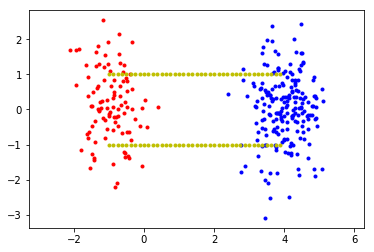

In [8]:
puntos=200
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar

#OJO GUARDO LA DATA COMO XY XY XY XY (no como XXXX YYYYY ) 

y1, y2 = np.random.multivariate_normal([4,0], [[0.3,0],[0,1]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1,0], [[0.3,0],[0,1]], puntos//2).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()


top=np.ones((40,2))
bottom=-np.ones((40,2))
dx=5/top.shape[0]
for i in range(top.shape[0]):
    top[i,0]=i*dx-1
    bottom[i,0]=i*dx-1

plt.axis('equal')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')


In [9]:
data=np.concatenate((Zcol,Ycol,bottom,top),axis=0)

alpha=2
k=10
finalData=Ycol
initialData=Zcol-[2,0]

xinit=np.random.random(Zcol.shape)

#FILTRO WARNINGS!!
import warnings
warnings.filterwarnings('ignore')

res=fermat_ot(data,initialData,finalData,alpha,k,xinit,maxiter=100)



Iter:1, cost: 227.85955075819334,  max constr-viol:15.99412134989128
Iter:2, cost: 229.29370391317846,  max constr-viol:15.896644817184443
Iter:3, cost: 232.50344402760751,  max constr-viol:14.83193549157551
Iter:4, cost: 463.34482695956956,  max constr-viol:9.11360890528859
Iter:5, cost: 290.53098921827205,  max constr-viol:1.3370289737817558
Iter:6, cost: 266.15677751983844,  max constr-viol:0.28442245579636705
Iter:7, cost: 261.9972874671532,  max constr-viol:0.04098844985262318
Iter:8, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:9, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:10, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:11, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:12, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:13, cost: 258.716663256872,  max constr-viol:0.025700986993346425
Iter:14, cost: 258.1489354271179,  max constr-viol:0.018868161715356817
Iter:15, cos

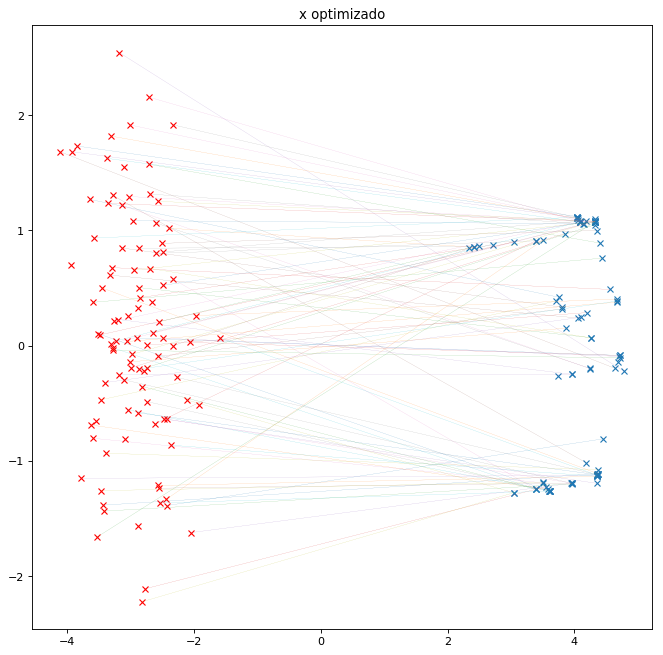

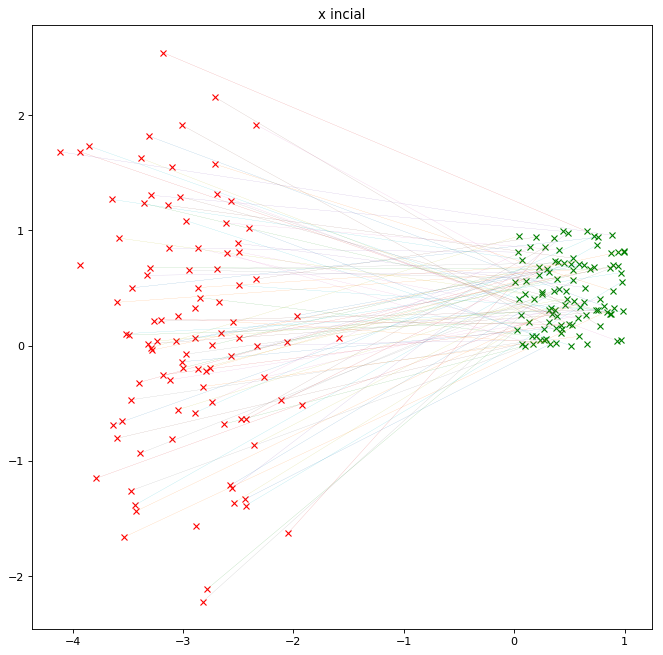

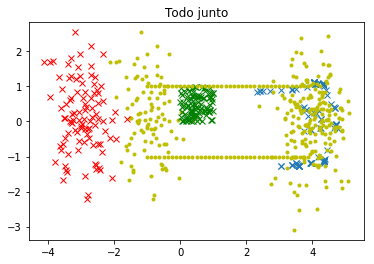

In [10]:
dimension=2

X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9 #PORCENTAJE DE LINEAS QUE PLOTEO



from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
x=X_t[:,0]
y=X_t[:,1]

plt.plot(x,y,'x')
plt.plot(initialData[:,0],initialData[:,1],'x',c='r')

#plt.plot(y1,y2,'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([initialData[i,0],x[i]],[initialData[i,1],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])



figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
inicial=xinit

plt.plot(initialData[:,0],initialData[:,1],'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')

for i in range(int(len(x)*percent)):
    plt.plot([initialData[i,0],inicial[i,0]],[initialData[i,1],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'.',c='y')
plt.plot(y1,y2,'.',c='y')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')
plt.plot(initialData[:,0],initialData[:,1],'x',c='r')

plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()

# DE ACA PARA ABAJO SON PRUEBAS, MAS DESPROLIJO:

## Barycenter: NO es tan simple reformularlo a la version de samples. Ahora lo que se mueve son los 'y' que seran la muestra del baricentro. Estos van a ser los initialData (PROBLEMA, HAY QUE DEFINIR OPTIMAL TRANSPORT CON INITIAL DATA FUERA DE LA SUPERFICIE) y los quiero mandar a cada uno de los x1,x2,x3... muestras de las distintas distribuciones. El costo será la suma de los costos c(y,x1)+c(y,x2)+c(y,x3) donde cada uno es un problema de optimizacion ya resuleto por fermat_opt. O sea, resuelvo cada uno de los tres problemas, me fijo el costo de cada solucion y los sumo. Ese será el costo de mi baricentro.

## Gradiente para este costo del baricentro?? Ya es bastante dificil, no tengo definido el gradiente de lo que cuesta transportar!

### Sería cuanto varía el costo de transporte si muevo un poquito un punto inicial: usar lo mismo que antes porque el fermat cost(x,y)= fermat cost(y,x). Entonces pienso que el punto al que mapea sigue siendo el mismo que esta fijo, el x y ya estoy.

# Algoritmo:
## Definir 'y' inicial
## Repetir:
###          resolver fermat_ot que mande y a x1,x2,x3,... Los puntos transportados serán x'1,x'2,x'3,... y los costos c1,c2,c3,...
###           costo de 'y'=c1+c2+c3+...
###           calcular gradiente de 'y' dados x'1,x'2,x'3,...
###           actualizar 'y' con descenso por el gradiente o cualquier tecnica de optimizacion


# Caluclo gradiente de 'y' dado x'1,x'2,x'3:
### para cada punto de 'y', mirar sus k vecinos mas cercanos y quedarse con el de menor distancia de fermat desde  su asignado en x'1 (que no esta en el manifold!). Sumar tanto con x'1,x'2,x'3...

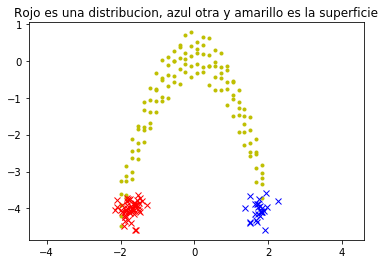

In [14]:
puntos=25

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)
#W=np.concatenate((W,-W-[0,8]),axis=0)

"""


W=np.concatenate((W,np.random.random((300,2))*[4,1]-[2,4.5]),axis=0)


W=np.random.random((300,2))*[4,1]-[2,4.5]
"""

y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos*2).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

# CON GRADIENTE

In [15]:
def cost_function(y,data,f_dist,tree,distributions,alpha,k,k2,maxiter=30):
    dimension=data.shape[1]
    real_y=y.reshape(-1,dimension)
    cost=0
    gradient=np.zeros(y.shape)
    
    transporteds=[]
    
    for distribution in distributions:
        
        xinit=real_y
        
        initialPoints=real_y.shape[0]
        cons=constraints(initialPoints,distribution)
    
        res=fermat_opt_transport(real_y,dimension,f_dist,tree,data,k,alpha,cons,xinit,callback=False,maxiter=maxiter)
        
        cost_for_distr=res['fun']
        y_transported_for_distr=res['x'].reshape(-1,dimension)
        
        transporteds.append(y_transported_for_distr)
        
        cost+=cost_for_distr
        
    gradient=fermat_grad(real_y,transporteds,f_dist,tree,k,k2,alpha,data)
        
    return cost,gradient

def fermat_grad(y,transporteds,fermat_distances,tree,k,k2,alpha,data):
    dimension=y.shape[1]
    gradient=np.zeros(y.flatten().shape)
    for i in range(y.shape[0]):
        y_loc=y[i,:]
        trash,neighbours_ind=tree.query([y_loc],k=k2) #elijo k2 vecinos de un punto (indices de data)
        cost_neighbours=[]
        for ind in neighbours_ind[0]: #para cada vecino
            start=data[ind,:] #el vecino
            cost_for_neighbour=0
            for transported in transporteds: #sumo cuanto cuesta llevarlo a su correspondiente
                end=transported[i,:] #su correspondiente
                dist,trash=fermat_dist(start,end,fermat_distances,tree,k,alpha)
                cost_for_neighbour+=dist
                
            cost_neighbours.append(cost_for_neighbour)
        q_idx=np.argmin(cost_neighbours) #el vecino que minimiza
        q=data[neighbours_ind[0,q_idx],:] #el punto de ese vecino
        loc_grad=(y[i,:]-q)
        gradient[i*dimension:(i+1)*dimension]=loc_grad
    return gradient
        
        
                
  
              


data=np.concatenate((Ycol,Zcol,W),axis=0)

distributions=[Ycol,Zcol] #a lo que le voy a tomar baricentro

alpha=2
k=30
k2=50

f_dist,tree=fermat_graph(data,alpha)
    
yinit=np.random.random((puntos,2))-0.5 -[0,8]

opti={"disp": True, "maxiter":100}
    
g= lambda x: cost_function(x,data,f_dist,tree,distributions,alpha,k,k2,maxiter=100)
    
global Nfevalposta
Nfevalposta=1
def callbackFposta(Xi,status=None):
    global Nfevalposta
    print ('POSTA Iter:'+ str(Nfevalposta)+', cost: '+str(g(Xi)[0]))
    Nfevalposta += 1

    
#ELEGIR METODO ACA!!!
#Ya probe el x defecto, no va.

#SLSQP va bien aca
meth='SLSQP'
resposta = minimize(g, x0=yinit.flatten(),jac=True,method=meth,options=opti,callback=callbackFposta)

POSTA Iter:1, cost: 56.26254460206588
POSTA Iter:2, cost: 56.38072671373495
POSTA Iter:3, cost: 75.51471070509187
POSTA Iter:4, cost: 58.044596985456394
POSTA Iter:5, cost: 57.37088815368675
POSTA Iter:6, cost: 55.983093597549264
POSTA Iter:7, cost: 61.13323787728508
POSTA Iter:8, cost: 12681.29684532437
POSTA Iter:9, cost: 502527.6898345715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 52.61603745648519
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9


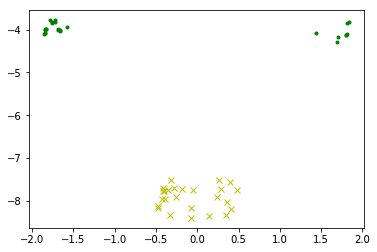

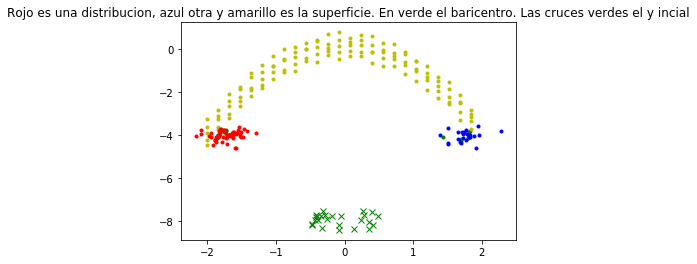

In [16]:
barycenter=resposta['x']
barycenter=barycenter.reshape(-1,2)
plt.plot(barycenter[:,0],barycenter[:,1],'.',c='g')

plt.plot(yinit[:,0],yinit[:,1],'x',c='y')
plt.show()

plt.plot(barycenter[:,0],barycenter[:,1],'.',c='g')
plt.plot(yinit[:,0],yinit[:,1],'x',c='g')
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie. En verde el baricentro. Las cruces verdes el y incial')
plt.show()

In [17]:
g(yinit.flatten())[0]

720.0825824869364

In [18]:
g(barycenter.flatten())[0]

52.61603745648519

In [28]:
g((np.zeros(yinit.shape)-[-2,4]).flatten())[0]

0.37681174290243835

In [27]:
g(np.zeros(yinit.shape).flatten())[0]

29.451906996290468

In [29]:
g((np.zeros(yinit.shape)-[2,4]).flatten())[0]

0.5231888180260308

In [22]:
g(Ycol.flatten())[0]

56.532218523330215

In [23]:
g(Zcol.flatten())[0]

202.5266692513033

# PROBLEMAS:

### No puedo definir un gradiente para el costo de que una distribucion sea baricentro. Prque si uso la suma de gradiente de costos, medio que el tipo no se da cuenta que esta mas cerca de uno que de otro... 

### Propuesta: definir un gradiente que sea EN VEZ DE sum_i (el vector que apunta al k-nn de menor costo al correspondiente de cada x'i) 

###  definir que el gradiente apunte a alguno de los k vecinos con min( sum_i costos de transporte a los corrrespondientes x'i). 

##### La longitud del gradiente la dejo como esa flecha directamente... (alguna idea?)

# DUDAS

## Sigue andando bastante flojo, quizas necesito poblar mas la superficie??

## Cual es la restriccion que le tengo que poner a la distribucion baricentro? Por que no le conviene entonces ser un punto o  porque tiene que tener una forma "parecida" a las distribuciones?

# ENFOQUE DE OPTIMIZACION COMBINATORIA USANDO LA LIBRERIA POT

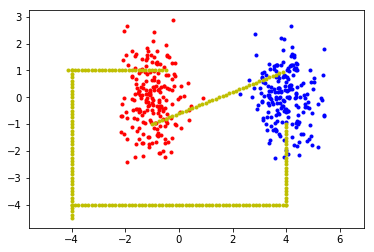

In [34]:
puntos=200
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar

#OJO GUARDO LA DATA COMO XY XY XY XY (no como XXXX YYYYY ) 

y1, y2 = np.random.multivariate_normal([4,0], [[0.3,0],[0,1]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1,0], [[0.3,0],[0,1]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()


top=-np.ones((40,2))
dx=5/top.shape[0]
for i in range(top.shape[0]):
    top[i,:]=[i*dx-1,0.4*i*dx-1]
    
    

bottom=np.ones((30,2))-[1.5,0]

dx=5/top.shape[0]
for i in range(bottom.shape[0]):
    bottom[i,0]-=i*dx
    
bottom2=np.ones((45,2))-[5,0]

dx=5/top.shape[0]
for i in range(bottom2.shape[0]):
    bottom2[i,1]-=i*dx
    
bottom3=np.ones((65,2))-[5,5]

dx=5/top.shape[0]
for i in range(bottom3.shape[0]):
    bottom3[i,0]+=i*dx
    
bottom4=np.ones((25,2))+[3,-5]

dx=5/top.shape[0]
for i in range(bottom4.shape[0]):
    bottom4[i,1]+=i*dx

bottom=np.concatenate((bottom,bottom2,bottom3,bottom4),axis=0)
    
plt.axis('equal')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')

Text(0.5, 1.0, 'OT matrix with samples')

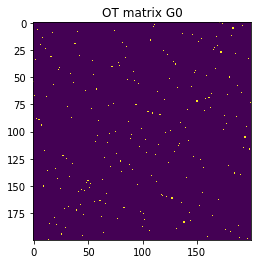

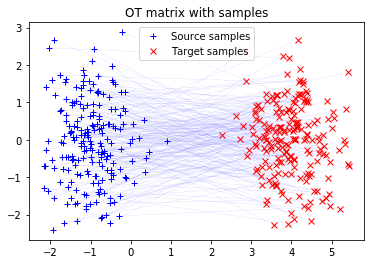

In [36]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import fermat as F
from scipy.spatial import  distance_matrix

data=np.concatenate((Zcol,Ycol,bottom,top),axis=0)
n=puntos
a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
alpha=3
method='FW'
model=F.Fermat(alpha, path_method=method,k=100)
model.fit(np.matrix(distance_matrix(data,data)))
fermat_distances = model.get_distances()


M = fermat_distances[0:n,n:2*n]
M=np.ascontiguousarray(M)
M /= M.max()


G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')


xs=Zcol
xt=Ycol
pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1],lw=0.1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

